In [1]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import opinionated  # noqa: F401
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap

from rs_graph.db import constants as db_constants

plt.style.use("opinionated_rc")
 
CMAPS_BOLD_PALETTE = cmaps.bold._colors.tolist()

###############################################################################


def _read_table(table: str) -> pl.DataFrame:
    return pl.read_database_uri(
        f"SELECT * FROM {table}",
        f"sqlite:///{db_constants.V2_DATABASE_PATHS.dev}",
    )


def load_pairs() -> pl.DataFrame:
    # Read all the tables we need
    dataset_sources = _read_table("dataset_source")
    docs = _read_table("document")
    repos = _read_table("repository")
    pairs = _read_table("document_repository_link")
    doc_topics = _read_table("document_topic")
    topics = _read_table("topic")

    # Drop to unique doc and unique repo in pairs
    pairs = pairs.unique(
        subset="document_id",
        keep="none",
    ).unique(
        subset="repository_id",
        keep="none",
    )

    # Create a table of document_authors
    # and their country institutional affiliations
    # then group by document to get to document_country_affiliation
    doc_contribs = _read_table("document_contributor")
    doc_contrib_institutions = _read_table("document_contributor_institution")
    institutions = _read_table("institution")

    doc_author_countries = doc_contribs.select(
        pl.col("id").alias("document_contributor_id"),
        pl.col("researcher_id"),
        pl.col("document_id"),
    ).join(
        doc_contrib_institutions.select(
            "document_contributor_id",
            "institution_id",
        ),
        on="document_contributor_id",
        how="left",
    ).join(
        institutions.select(
            pl.col("id").alias("institution_id"),
            "country_code",
        ),
        on="institution_id",
        how="left",
    ).with_columns(
        pl.when(pl.col("country_code").is_null()).then(
            pl.lit("Unknown")
        ).otherwise(pl.col("country_code"))
    ).group_by(
        "document_id"
    ).agg(
        pl.len().alias("document_n_authors"),
        pl.when(pl.col("country_code").n_unique() == 1).then(
            pl.col("country_code").get(0)
        ).otherwise(
            pl.lit("Multiple")
        )
    ).with_columns(
        pl.when(pl.col("country_code").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("country_code"))
        .alias("country_code")
    )

    # Get repo_contribs count
    repo_contribs = _read_table("repository_contributor")
    repo_contribs = repo_contribs.group_by(
        "repository_id"
    ).len("repository_n_contributors")

    # Join the tables to get the positive examples
    return (
        pairs.select(
            "document_id",
            "repository_id",
            "dataset_source_id",
            pl.col("predictive_model_confidence").alias("document_repository_link_confidence"),
        )
        .join(
            docs.select(
                pl.col("id").alias("document_id"),
                pl.col("cited_by_count").alias("document_cited_by_count"),
                pl.col("fwci").alias("document_fwci"),
                pl.col("is_open_access").alias("document_is_open_access"),
                pl.col("publication_date").alias("document_publication_date"),
            ),
            on="document_id",
            how="left",
        )
        .join(
            repos.select(
                pl.col("id").alias("repository_id"),
                pl.col("stargazers_count").alias("repository_stargazers_count"),
                pl.col("commits_count").alias("repository_commits_count"),
                pl.col("primary_language").alias("repository_primary_language"),
                pl.col("creation_datetime").alias("repository_creation_datetime"),
            ),
            on="repository_id",
            how="left",
        ).join(
            dataset_sources.select(
                pl.col("id").alias("dataset_source_id"),
                pl.col("name").alias("dataset_source_name"),
            ),
            on="dataset_source_id",
            how="left",
        ).join(
            doc_topics.sort(
                "score",
                descending=True,
            ).unique(
                "document_id",
                maintain_order=True,
            ).select(
                pl.col("document_id").alias("document_id"),
                pl.col("topic_id").alias("topic_id"),
            ),
            on="document_id",
            how="left",
        ).join(
            topics.select(
                pl.col("id").alias("topic_id"),
                pl.col("domain_name").alias("document_domain_name"),
                pl.col("field_name").alias("document_field_name"),
            ),
            on="topic_id",
            how="left",
        ).join(
            doc_author_countries,
            on="document_id",
            how="left",
        ).join(
            repo_contribs,
            on="repository_id",
            how="left",
        )
    )


df = load_pairs()
df

# Drop any rows with document_repository_link_confidence of less than 0.995
df = df.filter(
    (pl.col("document_repository_link_confidence") >= 0.995)
    | (pl.col("document_repository_link_confidence").is_null())
)

# Get consistent hue order and col order by sorting the dataset source names
dataset_source_names = (
    df.select("dataset_source_name")
    .unique()
    .sort("dataset_source_name")["dataset_source_name"]
    .to_list()
)

/Users/evamaxfield/.local/share/mamba/envs/rs-graph/lib/python3.12/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added n

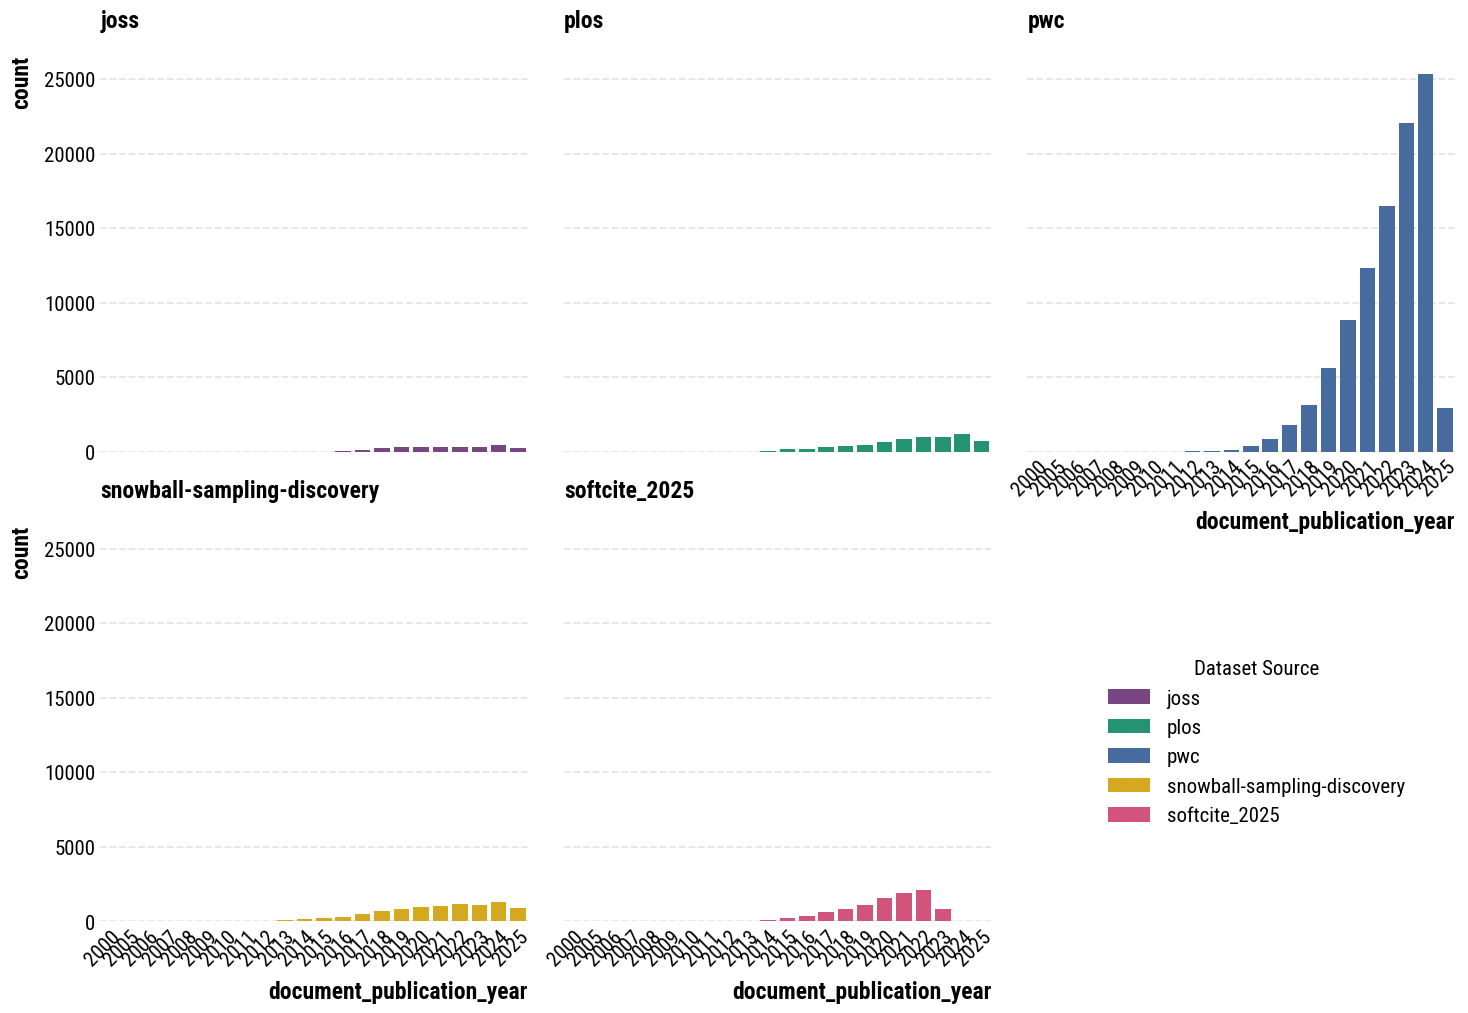

In [2]:
# Create publication year column
df = df.with_columns(
    pl.col("document_publication_date").dt.year().alias("document_publication_year"),
)

# Plot publication date
g = sns.catplot(
    data=df,
    kind="count",
    x="document_publication_year",
    hue="dataset_source_name",
    col="dataset_source_name",
    col_wrap=3,
    col_order=dataset_source_names,
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
)

# Change titles
g.set_titles("{col_name}")

# Rotate x-axis labels
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Move legend to lower right
sns.move_legend(
    g,
    "lower right",
    bbox_to_anchor=(0.80, 0.15),
    title="Dataset Source",
    frameon=False,
)

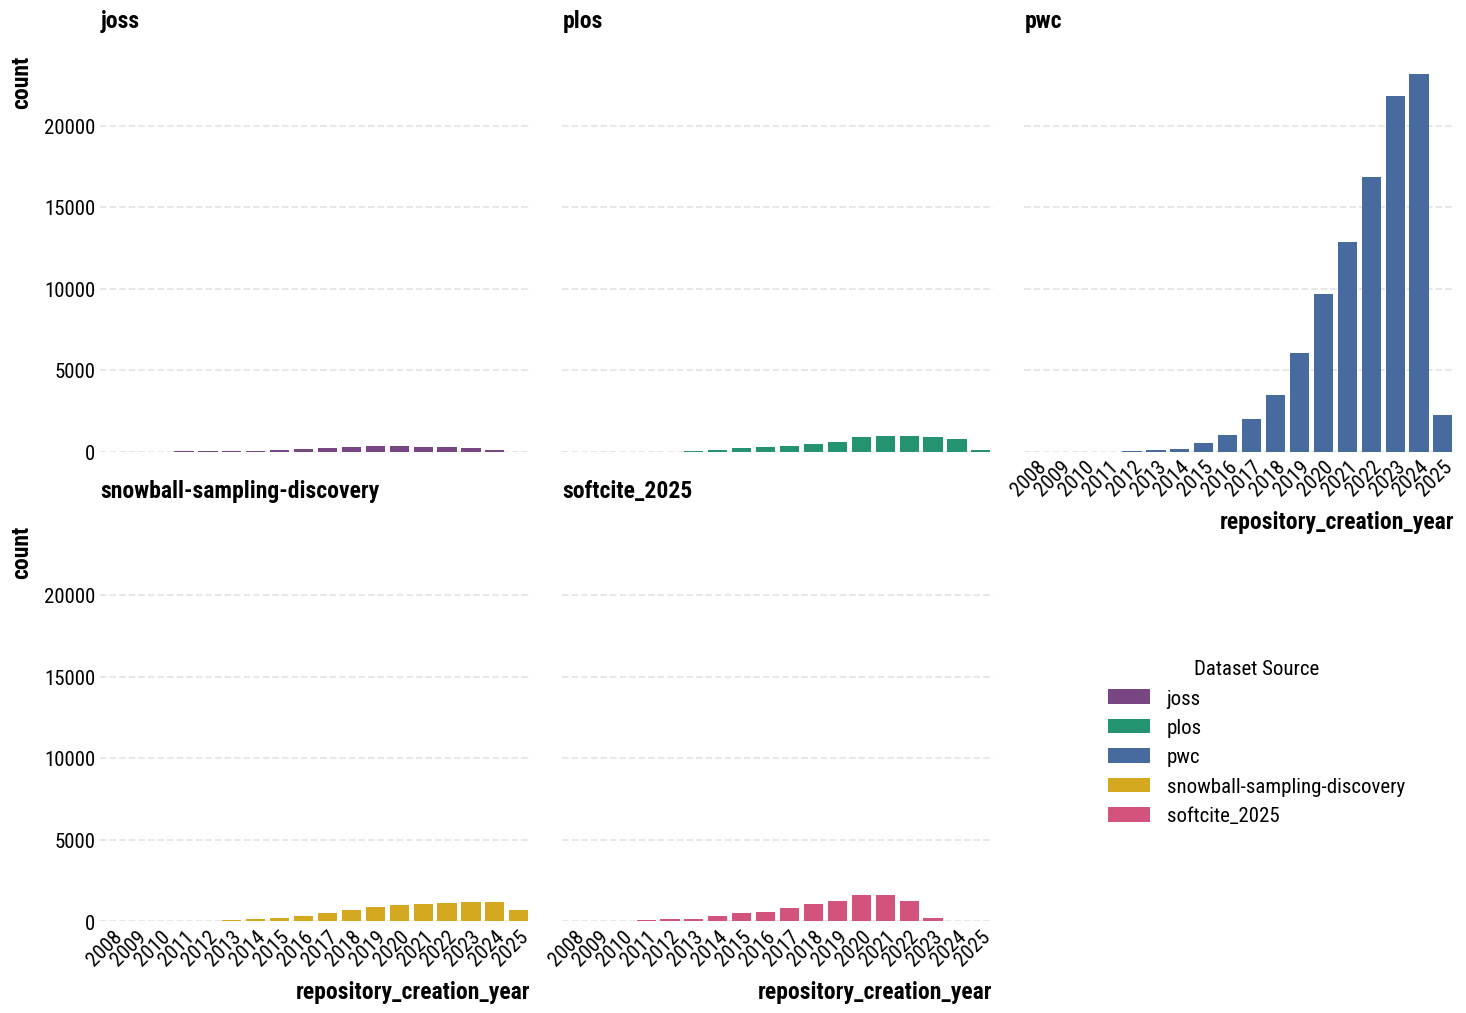

In [3]:
# Same thing but with repository creation date
df = df.with_columns(
    pl.col("repository_creation_datetime").dt.year().alias("repository_creation_year"),
)

# Plot repository creation date
g = sns.catplot(
    data=df,
    kind="count",
    x="repository_creation_year",
    hue="dataset_source_name",
    col="dataset_source_name",
    col_wrap=3,
    col_order=dataset_source_names,
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
)

# Change titles
g.set_titles("{col_name}")

# Rotate x-axis labels
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Move legend to lower right
sns.move_legend(
    g,
    "lower right",
    bbox_to_anchor=(0.80, 0.15),
    title="Dataset Source",
    frameon=False,
)

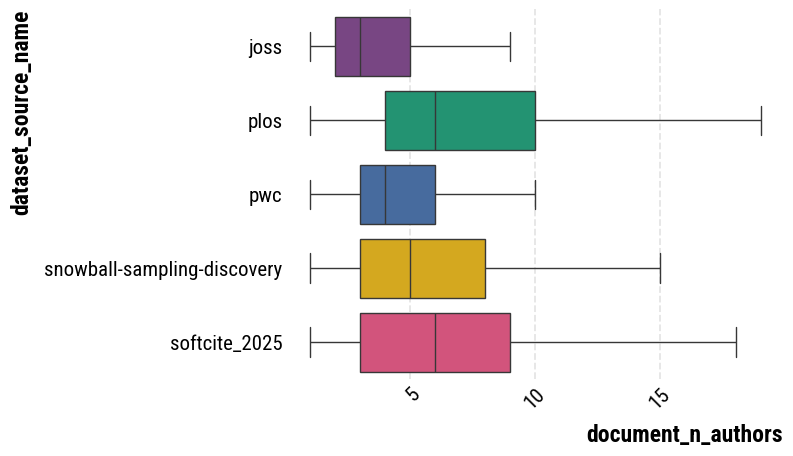

In [4]:
# Box plot of author count distribution
ax = sns.boxplot(
    data=df,
    x="document_n_authors",
    y="dataset_source_name",
    order=dataset_source_names,
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

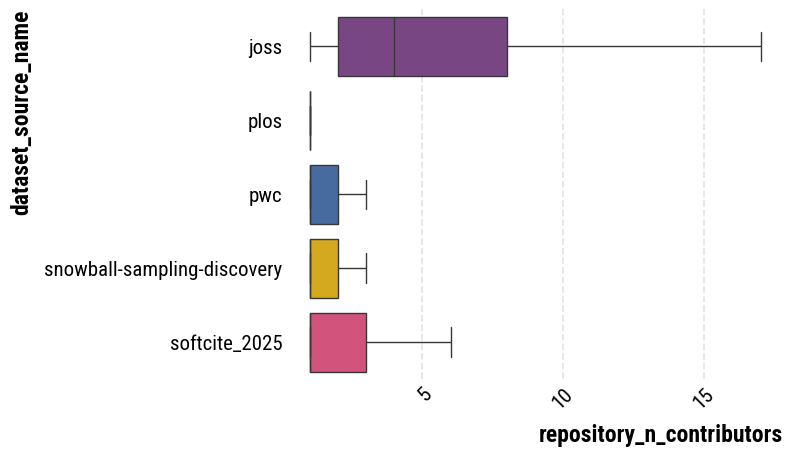

In [5]:
# Box plot of contributor count distribution
ax = sns.boxplot(
    data=df,
    x="repository_n_contributors",
    y="dataset_source_name",
    order=dataset_source_names,
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

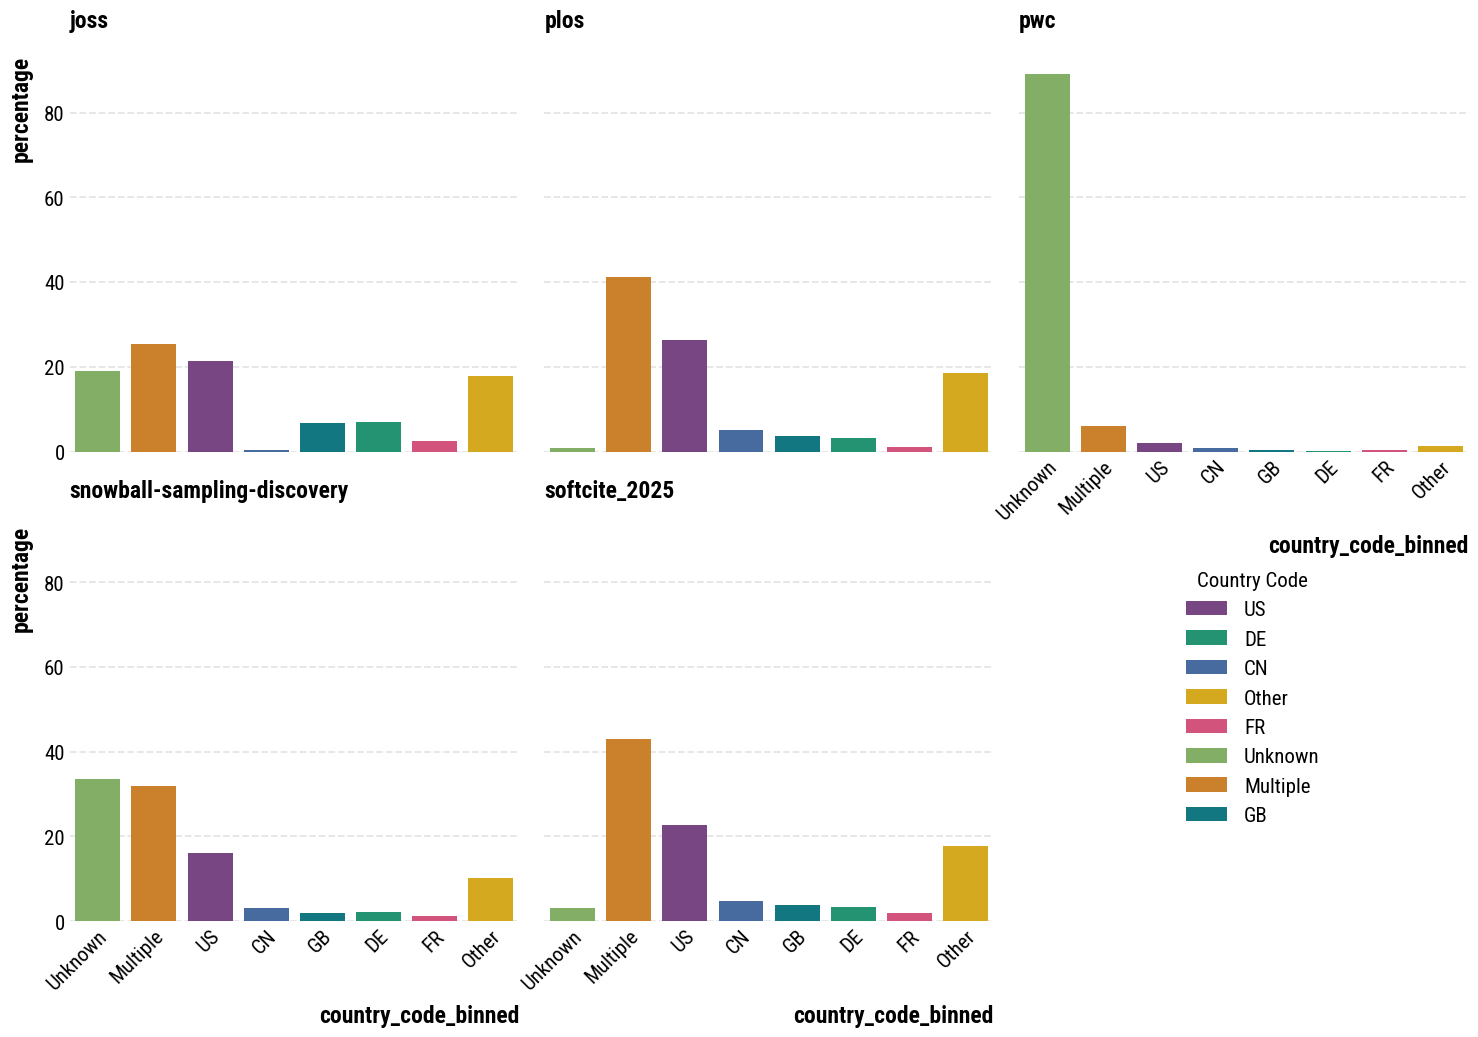

In [6]:
# Get top 8 country_codes and then "Other"
top_countries = (
    df.select("country_code")
    .group_by("country_code")
    .len("count")
    .sort("count", descending=True)
    .head(7)
    .select("country_code")["country_code"]
    .to_list()
)

df = df.with_columns(
    pl.when(pl.col("country_code").is_in(top_countries))
    .then(pl.col("country_code"))
    .otherwise(pl.lit("Other"))
    .alias("country_code_binned")
)

# Prep as a percentage of total per dataset source
country_code_counts = (
    df.select(
        "dataset_source_name",
        "country_code_binned",
    )
    .group_by(
        "dataset_source_name",
        "country_code_binned",
    )
    .len("count")
    .with_columns(
        pl.col("count").sum().over("dataset_source_name").alias("total_count"),
    )
    .with_columns(
        (pl.col("count") / pl.col("total_count") * 100).alias("percentage"),
    )
)

# Plot barplot of country_code distribution
g = sns.catplot(
    data=country_code_counts.to_pandas(),
    kind="bar",
    x="country_code_binned",
    y="percentage",
    hue="country_code_binned",
    order=top_countries + ["Other"],
    col="dataset_source_name",
    col_wrap=3,
    col_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:8],
    legend=True,
)

# Change titles
g.set_titles("{col_name}")

# Rotate x-axis labels
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Move legend to lower right
sns.move_legend(
    g,
    "lower right",
    bbox_to_anchor=(0.80, 0.15),
    title="Country Code",
    frameon=False,
)

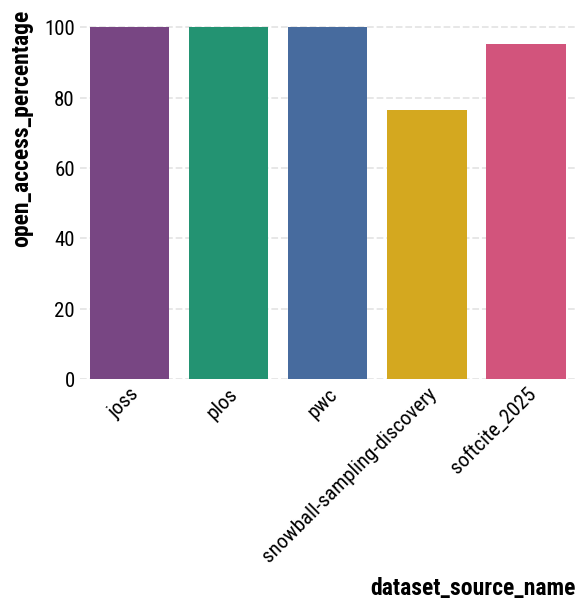

In [7]:
# Prep for visualizations of is_open_access by grouping by dataset source
# and then getting percentage of open access documents
df_oa = (
    df.group_by("dataset_source_name")
    .agg(
        [
            pl.col("document_is_open_access").sum().alias("open_access_count"),
            pl.count("document_id").alias("total_count"),
        ]
    )
    .with_columns(
        (pl.col("open_access_count") / pl.col("total_count") * 100).alias("open_access_percentage"),
    )
)

ax = sns.barplot(
    data=df_oa,
    x="dataset_source_name",
    y="open_access_percentage",
    order=dataset_source_names,
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
)

# Rotate x-axis labels
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

<Axes: xlabel='document_cited_by_count', ylabel='dataset_source_name'>

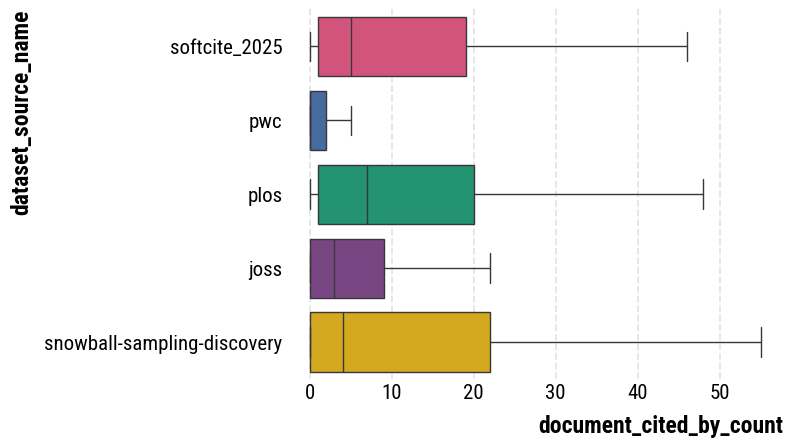

In [8]:
# Plot distribution of cite_by_count
sns.boxplot(
    data=df,
    x="document_cited_by_count",
    y="dataset_source_name",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

<Axes: xlabel='document_fwci', ylabel='dataset_source_name'>

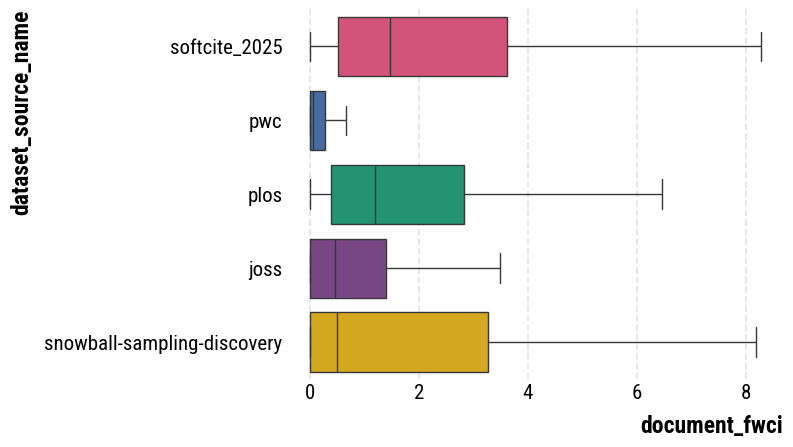

In [9]:
# Plot distribution of cite_by_count
sns.boxplot(
    data=df,
    x="document_fwci",
    y="dataset_source_name",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

<Axes: xlabel='repository_stargazers_count', ylabel='dataset_source_name'>

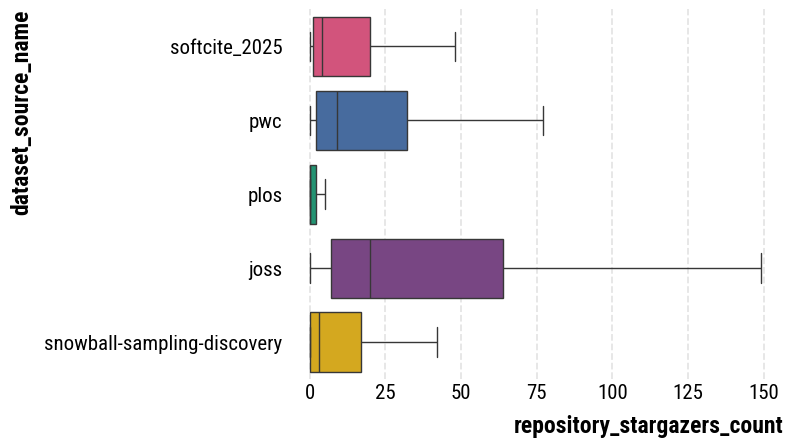

In [10]:
# Plot distribution of stargazers_count
sns.boxplot(
    data=df,
    x="repository_stargazers_count",
    y="dataset_source_name",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

<Axes: xlabel='repository_commits_count', ylabel='dataset_source_name'>

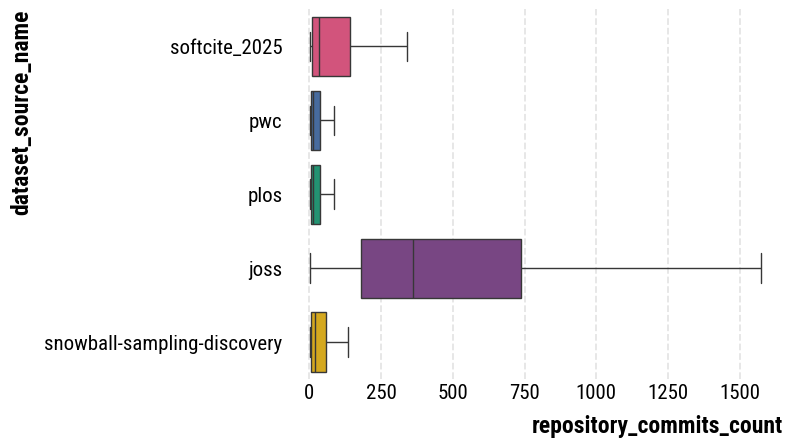

In [11]:
# Plot distribution of commits_count
sns.boxplot(
    data=df,
    x="repository_commits_count",
    y="dataset_source_name",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

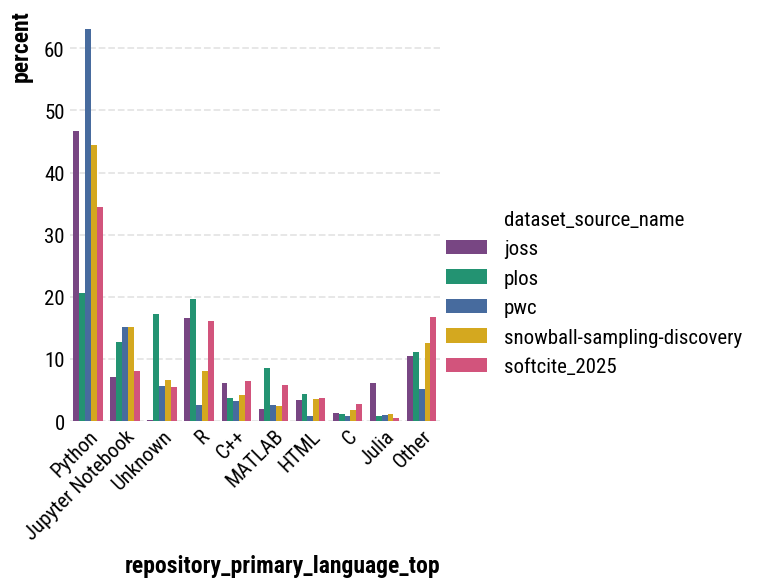

In [12]:
# Get top 9 primary repository programming languages and then "other"
top_languages = (
    df.select("repository_primary_language")
    .group_by("repository_primary_language")
    .len("count")
    .sort("count", descending=True)
    .head(9)["repository_primary_language"]
    .to_list()
)

df = df.with_columns(
    pl.when(pl.col("repository_primary_language").is_in(top_languages))
    .then(pl.col("repository_primary_language"))
    .when(pl.col("repository_primary_language").is_null())
    .then(pl.lit("Unknown"))
    .otherwise(pl.lit("Other"))
    .alias("repository_primary_language_top"),
)

# Replace None in top_languages with "Unknown"
top_languages = [lang if lang is not None else "Unknown" for lang in top_languages]

# Create dataframe for visualization by grouping by dataset source
# And getting percent of each primary language within each dataset source
df_lang = (
    df.group_by(
        "dataset_source_name",
        "repository_primary_language_top",
    )
    .len("count")
    .with_columns(
        pl.col("count").sum().over("dataset_source_name").alias("total_count"),
    )
    .with_columns(
        (pl.col("count") / pl.col("total_count") * 100).alias("percent"),
    )
)

# Plot barplot of primary languages by dataset source
ax = sns.catplot(
    data=df_lang,
    kind="bar",
    x="repository_primary_language_top",
    y="percent",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    order=top_languages + ["Other", "Unknown"],
    palette=CMAPS_BOLD_PALETTE[:5],
)

# Rotate x-axis labels
_ = plt.setp(ax.ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

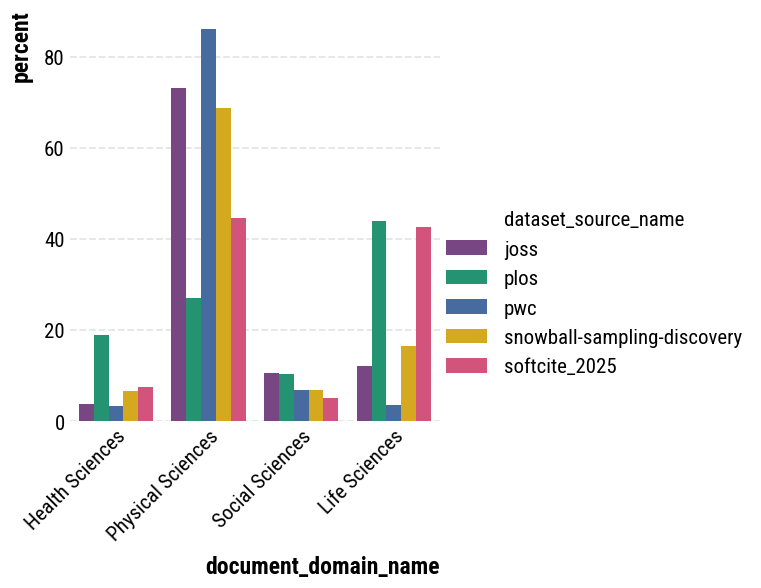

In [13]:
# Create dataframe for visualization by grouping by dataset source
# And getting percent of each domain within each dataset source
df_domain = (
    df.group_by(
        "dataset_source_name",
        "document_domain_name",
    )
    .len("count")
    .with_columns(
        pl.col("count").sum().over("dataset_source_name").alias("total_count"),
    )
    .with_columns(
        (pl.col("count") / pl.col("total_count") * 100).alias("percent"),
    )
)

# Plot barplot of domains by dataset source
ax = sns.catplot(
    data=df_domain,
    kind="bar",
    x="document_domain_name",
    y="percent",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
)

# Rotate x-axis labels
_ = plt.setp(ax.ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

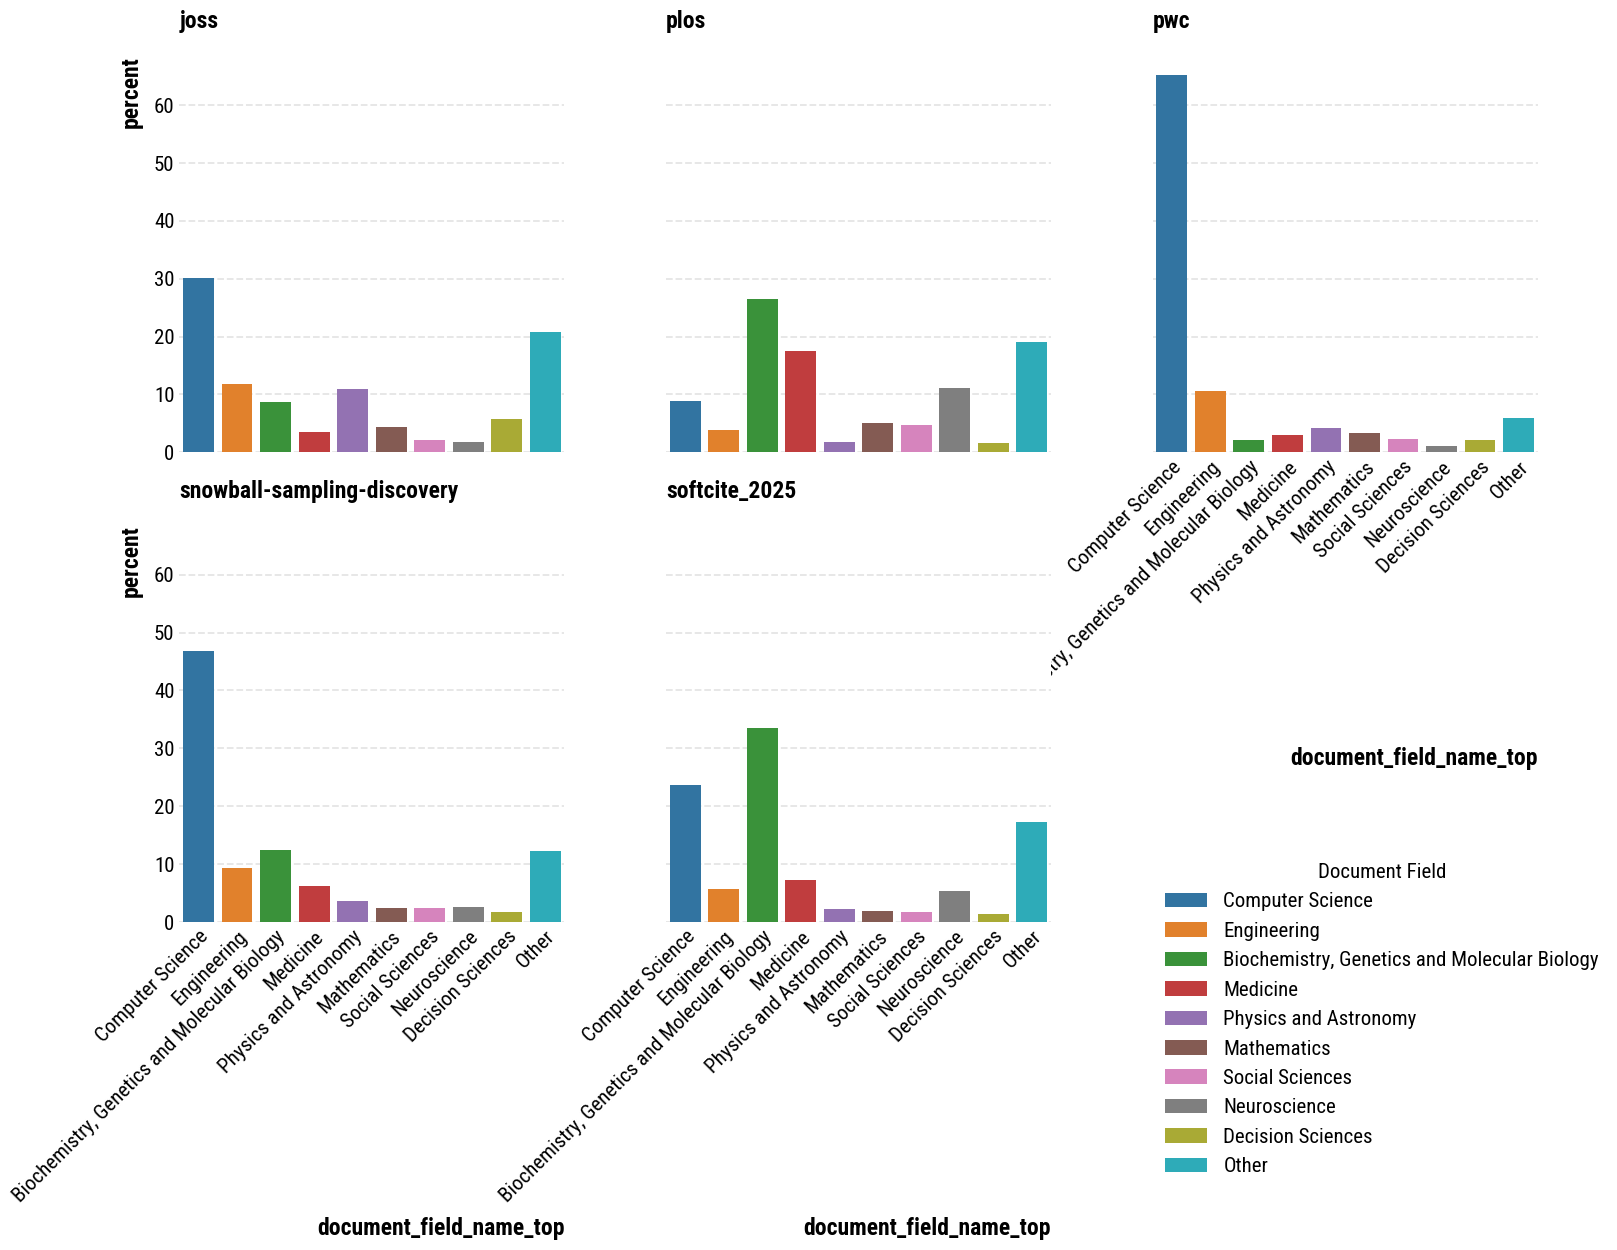

In [14]:
# Take top 9 fields and then "other"
top_fields = (
    df.select("document_field_name")
    .group_by("document_field_name")
    .len("count")
    .sort("count", descending=True)
    .head(9)["document_field_name"]
    .to_list()
)

df = df.with_columns(
    pl.when(pl.col("document_field_name").is_in(top_fields))
    .then(pl.col("document_field_name"))
    .otherwise(pl.lit("Other"))
    .alias("document_field_name_top"),
)

# Create dataframe for visualization by grouping by dataset source
# And getting percent of each field within each dataset source
df_field = (
    df.group_by(
        "dataset_source_name",
        "document_field_name_top",
    )
    .len("count")
    .with_columns(
        pl.col("count").sum().over("dataset_source_name").alias("total_count"),
    )
    .with_columns(
        (pl.col("count") / pl.col("total_count") * 100).alias("percent"),
    )
)

# Create a categorical to order lut
category_lut = {field: i for i, field in enumerate(top_fields + ["Other"])}

# Sort by top fields
df_field = df_field.with_columns(
    pl.Series(
        "document_field_name_top_order",
        [category_lut[field] for field in df_field["document_field_name_top"]],
    ),
).sort("document_field_name_top_order").drop("document_field_name_top_order")

# Plot barplot of fields by dataset source
g = sns.catplot(
    data=df_field,
    kind="bar",
    x="document_field_name_top",
    y="percent",
    hue="document_field_name_top",
    col="dataset_source_name",
    col_wrap=3,
    col_order=dataset_source_names,
    legend=True,
)

# Change titles
g.set_titles("{col_name}")

# Rotate x-axis labels
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Move legend to lower right
sns.move_legend(
    g,
    "lower right",
    bbox_to_anchor=(0.8, -0.2),
    title="Document Field",
    frameon=False,
)

<Axes: xlabel='document_repository_link_confidence', ylabel='Count'>

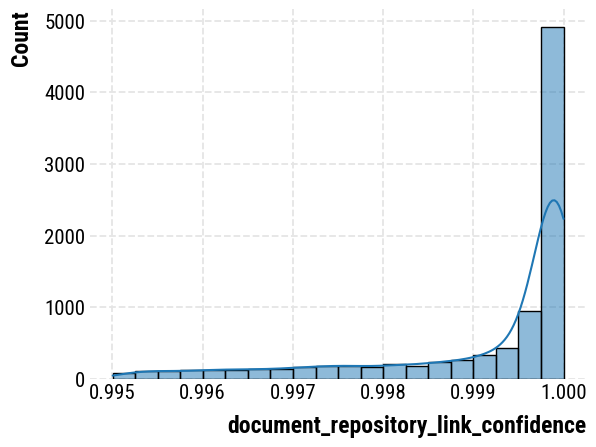

In [15]:
# Plot confidence scores of "snowball-sampling-discovery"
sns.histplot(
    data=df.filter(
        pl.col("dataset_source_name") == "snowball-sampling-discovery",
    ),
    x="document_repository_link_confidence",
    bins=20,
    kde=True,
)

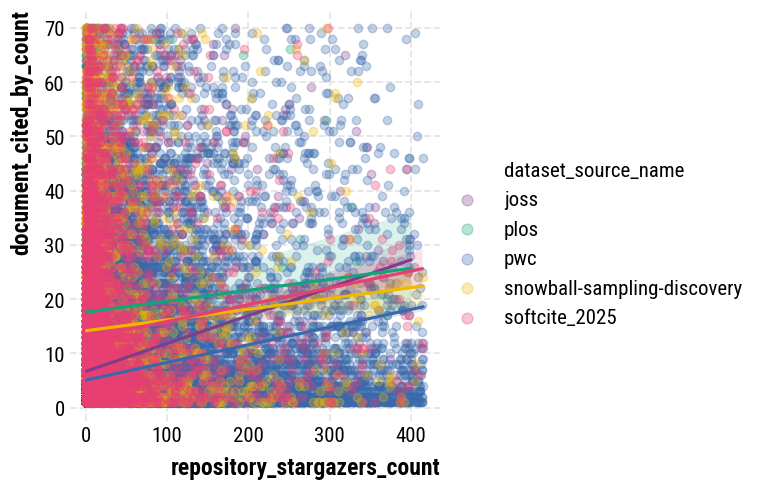

In [16]:
# Drop outliers in cited_by_count for better visualization
df_star_cite_corr = df.filter(
    (pl.col("document_cited_by_count") > pl.col("document_cited_by_count").quantile(0.03))
    & (pl.col("document_cited_by_count") < pl.col("document_cited_by_count").quantile(0.97))
    & (pl.col("repository_stargazers_count") > pl.col("repository_stargazers_count").quantile(0.03))
    & (pl.col("repository_stargazers_count") < pl.col("repository_stargazers_count").quantile(0.97))
)

# Correlate repo stars with cited_by_count
sns.lmplot(
    data=df_star_cite_corr,
    x="repository_stargazers_count",
    y="document_cited_by_count",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    scatter_kws={"alpha": 0.3},
)

<Axes: xlabel='days_between_publication_and_repo_creation', ylabel='dataset_source_name'>

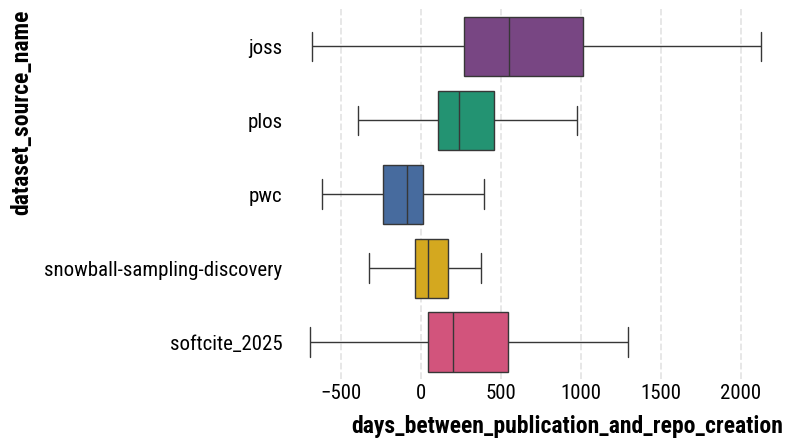

In [17]:
# Create a column of datetime difference between document publication date and repository creation date
df = df.with_columns(
    (pl.col("document_publication_date") - pl.col("repository_creation_datetime")).dt.total_days().alias("days_between_publication_and_repo_creation"),
)

# Plot distribution of days between publication and repo creation
sns.boxplot(
    data=df,
    x="days_between_publication_and_repo_creation",
    y="dataset_source_name",
    order=dataset_source_names,
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    showfliers=False,
)

In [18]:
# Get basic columns for UMAP
columns_for_umap = [
    "document_n_authors",
    "repository_n_contributors",
    "document_cited_by_count",
    # "document_fwci",
    "repository_stargazers_count",
    "repository_commits_count",
    "days_between_publication_and_repo_creation",
]

selected_data = df.select(
    [
        *columns_for_umap,
        "dataset_source_name",
    ],
).drop_nans().drop_nulls().sample(50000)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(
    StandardScaler().fit_transform(
        selected_data.select(columns_for_umap).drop_nans().drop_nulls().to_pandas(),
    )
)

# Prep UMAP dataframe
umap_df = pl.DataFrame(
    {
        "UMAP1": embedding[:, 0],
        "UMAP2": embedding[:, 1],
        "dataset_source_name": selected_data["dataset_source_name"],
    }
)

/Users/evamaxfield/.local/share/mamba/envs/rs-graph/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


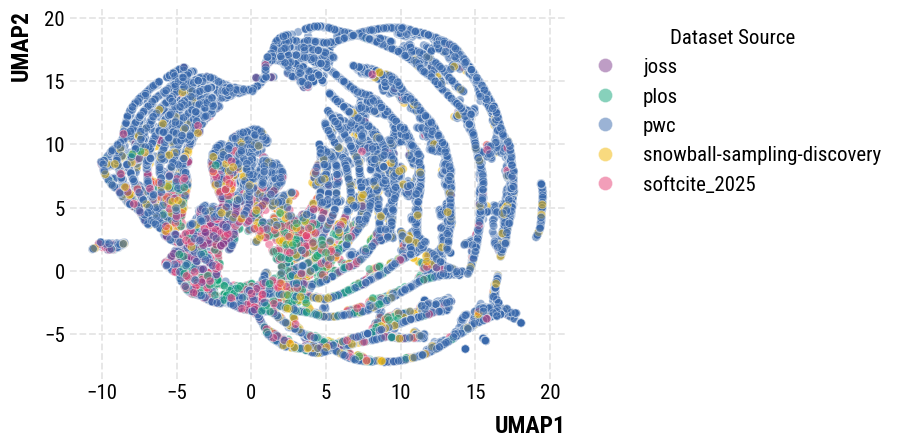

In [19]:
# Plot
ax = sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="dataset_source_name",
    hue_order=dataset_source_names,
    palette=CMAPS_BOLD_PALETTE[:5],
    alpha=0.5,
)

# Move legend
sns.move_legend(
    ax,
    "upper left",
    title="Dataset Source",
    frameon=False,
    bbox_to_anchor=(1, 1)
)